# Using convolutional neural network (CNN) to detect pneumonia from a chest xray

## Final Project Submission

Please fill out:


*   **Student Name:** Cassarra Groesbeck
*   **Student pace:** Part Time/ Flex
*   **Scheduled project review date/time:**
*   **Instructor name:**
*   **Blog post URL:**
---

# Introduction
**This notebook is intended for educational purposes, all scerios are hypothetical, and any resulting model(s) should not be used for any medical purposes.*

According to the latest publication from Meticulous Research®, the global X-ray detectors market is expected to register a CAGR of 6% during the forecast period 2022–2029 to reach $4.30 billion by 2029. The growing adoption of digital X-ray detectors, rising demand for X-ray imaging in industrial and security markets, growing geriatric population coupled with rising prevalence of chronic diseases & respiratory infections, and increasing utilization of X-ray detectors for early diagnosis & clinical applications are considered to have a positive impact on the global X-ray detectors market [[TOP 10 COMPANIES IN X-RAY DETECTORS MARKET]](https://meticulousblog.org/top-10-companies-in-x-ray-detectors-market/).

[GE Healthcare](https://www.gehealthcare.com/insights/article/achieving-greater-connectivity-in-radiology-through-digitization-and-ai) is among the top companies operating in the global digital radiography market [[Digital Radiography Market Size to Reach USD 19.82 Billion in 2028, Says Reports and Data]](https://www.biospace.com/article/digital-radiography-market-size-to-reach-usd-19-82-billion-in-2028-says-reports-and-data/). GE Healthcare is also leading the way with integration of AI into their imagaing equipment and software. They currently have on the market a collection of AI algorithms embedded on X-ray systems, Critical Care Suite 2.01 (CCS), for automated measurements, case prioritization, and quality control. It helps technologists reduce image quality errors and improves efficiency. This application automatically analyzes images on a GE X-ray system, highlights critical information on chest X-rays, including Endotracheal Tube Positioning & Pneumothorax Triage and Notifications [[GE Healthcare]](https://apps.gehealthcare.com/-/jssmedia/marketplace/products/ccs-2/documents/critical_care_suite_2_0_brochure_jb00538us.pdf?rev=6e8ff27ed896492b80b62c7e04a82eeb).


## Business Understanding

GE Healthcare would like to increase the marketability of their CCS system by expanding their collection of AI algorithms used when automatically analyzing images. One part of this expanded collection will screen for pneumonia. This will not only help GE Healthcare stay competative as the market grows but it will also increase the functionality of their CCS system. 

GE Healthcare needs a model that can successfully identify pneumonia. 



## Objectives 
Build and test a model that can detect pneumonia using chest ex ray images, to be integrate into GE Healthcare's collection of AI algorithms embedded in the Critical Care Suite 2.01 X-ray systems.

---

# Data Understanding

The dataset comes from Kermany et al. on [Mendeley Data](https://data.mendeley.com/datasets/rscbjbr9sj/3). Images are from Guangzhou Women and Children's Medical Center and contains frontal chest X-rays of children and women. This is a large dataset with 5856 total radiographs; 1583 NORMAL and 4273 PNEUMONIA, both bacterial pneumonia and viral pneumonia. 

---

# Imports

In [1]:
import os, shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
import numpy as np
import pandas as pd
from PIL import Image
from scipy import ndimage
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

np.random.seed(123)

# Functions

## View first 20 images in a data set
Similar to the way you may want to preview the head of a dataframe, I will use this function to quickly view the first 20 images of a dataset.

In [2]:
def preview_first_20(images, labels, title):
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10,10))
    for n in range(20):
        i = n //5
        j = n%5
        ax = axes[i][j]
        ax.imshow(images[n].reshape(256, 256), cmap=plt.cm.gray)
        ax.set_xticks([128])
        if labels[n] == 0:
            ax.set_xticklabels(['Normal'])
        else:
            ax.set_xticklabels(['Pneumonia'])
        ax.set_yticks([])
        if n == 2:
            ax.set_title(title, 
                         fontsize=25, 
                         pad=20);

## Plot loss and accuracy across epochs

This function will use the dictionary created during .fit method -OR- a pandas df, to plot a models loss and accuracy, of both training and validation data, across epochs

In [3]:
def plot_loss_accuracy(results_dict_or_df):
    train_loss = results_dict_or_df['loss']
    train_acc = results_dict_or_df['accuracy']
    val_loss = results_dict_or_df['val_loss']
    val_acc = results_dict_or_df['val_accuracy']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(x=range(len(train_loss)), y=train_loss, ax=ax1, label='train_loss')
    sns.lineplot(x=range(len(train_loss)), y=train_acc, ax=ax2, label='train_accuracy')

    sns.lineplot(x=range(len(train_loss)), y=val_loss, ax=ax1, label='val_loss')
    sns.lineplot(x=range(len(train_loss)), y=val_acc, ax=ax2, label='val_accuracy');

## Confusion Matrix and Classification Report
This function plots confusion matrix and classification report and gives the number and percentage of misclassified images as the plot title. It returns the indices of the misclassified images to use for plotting said images.

In [4]:
def evaluate_model(images, labels, predictions):
    # three variables to use in confusion matrix
    class_labels = list(train_downsampled_generator.class_indices.keys()) 
    true_classes = list(labels)
    predicted_classes = []
    
    # populate predicted_classes
    for prediction in predictions:
        if prediction >= .5:
            predicted_classes.append(1.)
        else:
            predicted_classes.append(0.)

    # get index of incorrect predictions
    indices_of_incorrect_predictions = []
    for n in range(len(true_classes)):
        if true_classes[n] != predicted_classes[n]:
            indices_of_incorrect_predictions.append(n)

    # number and percent of incorrect predictions
    n_incorrect_preds = len(indices_of_incorrect_predictions)
    total_cases = len(true_classes)
    percent_wrong = (n_incorrect_preds/total_cases)*100
    
    # save classification report as a dictionary
    report = classification_report(true_classes, 
                                   predicted_classes, 
                                   target_names=class_labels, 
                                   zero_division=0, 
                                   output_dict=True)   
    
    # plot confusion matrix and classification report side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
    
    fig.suptitle(f'This model mislabeled {n_incorrect_preds} images ({round(percent_wrong, 2)}%)', 
                 color='tab:blue', 
                 size=17)

    ax1.set_title("Confusion Matrix", size=15)
    ax2.set_title("Classification Report", size=15)

    ConfusionMatrixDisplay.from_predictions(true_classes, 
                                            predicted_classes, 
                                            cmap="Blues", 
                                            display_labels=class_labels, 
                                            ax=ax1);

    # code for plotting classification report inspired from:
    # https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, 
                annot=True, 
                vmin=.6, 
                vmax=1, 
                cmap="Blues", 
                linewidths=2, 
                ax=ax2);
    
    return indices_of_incorrect_predictions

## Convert the dictionary from .fit method to a pandas df
To save time when re running this notebook I will save each model after fitting. Converting the resulting results.history dictionary to a df is the easiest way to have access to data for plotting loss and accuracy when bypassing fit method.

In [5]:
def to_df(results_dict):
    return pd.DataFrame(results_dict, columns=results_dict.keys())

## Combine model.evaluate from training and test data into one df
With each model metrics saved in it's own df I can concatinate the dfs as I go - to easily assess progression. 


In [6]:
def dot_evaluate_to_df(models_string_name, model, x_train, y_train, x_test, y_test):
    # evaluate on training and test data
    train = model.evaluate(x_train, y_train, verbose=0)
    test = model.evaluate(x_test, y_test, verbose=0)
    # create dfs
    train_df = pd.DataFrame([train], columns=['train_loss', 'train_acc'], index=[models_string_name])
    test_df = pd.DataFrame([test], columns=['test_loss', 'test_acc'], index=[models_string_name])
    # combine dfs
    combo = pd.concat([train_df, test_df], axis=1)
    # add difference between train and test metrics to df
    combo['loss_diff'] = abs(combo['train_loss']-combo['test_loss'])
    combo['acc_diff'] = abs(combo['train_acc']-combo['test_acc'])
    
    return combo

## Downsampled and validation set indices
This is not really a function but in the spirit of replicability I want to provide the indices of the images I used in my downsampled and validation sets. This was needed after I had to use a backup copy of my notebook. The models were not performing in the same way until I started over unzipping data and re running everything. To ensure that did not happen again I included the indices below. 

In [7]:
reuse_downsample_indices_norm = [1143, 746, 1234, 1036, 1285, 186, 1034, 1123, 815, 148, 607, 990, 1231, 802, 327, 
                                 552, 887, 1011, 983, 623, 1213, 780, 658, 767, 444, 169, 917, 201, 875, 697, 240, 
                                 450, 203, 665, 73, 419, 653, 902, 648, 361, 315, 505, 980, 288, 1116, 270, 1132, 
                                 532, 686, 858, 299, 821, 774, 1288, 123, 1259, 323, 485, 424, 501, 1166, 118, 
                                 1320, 128, 528, 115, 120, 1273, 794, 912, 440, 1313, 1097, 666, 188, 539, 173, 
                                 1278, 324, 928, 1286, 460, 93, 1168, 1005, 1271, 866, 837, 218, 1252, 467, 449, 
                                 200, 246, 1058, 812, 106, 1015, 936, 347, 782, 720, 364, 80, 987, 159, 397, 949, 
                                 573, 226, 260, 459, 1104, 305, 915, 182, 184, 328, 922, 225, 1266, 1073, 1281, 52,
                                 1338, 604, 425, 553, 956, 1318, 385, 608, 963, 549, 1060, 918, 568, 310, 410, 701,
                                 322, 538, 1071, 1157, 797, 314, 304, 158, 1197, 151, 954, 311, 579, 303, 680, 1088, 
                                 1347, 961, 988, 1040, 421, 562, 1165, 921, 293, 427, 1180, 344, 876, 130, 1192, 
                                 400, 635, 54, 456, 679, 1153, 1035, 167, 994, 489, 703, 1163, 357, 1013, 546, 882,
                                 1210, 1101, 124, 1322, 637, 1181, 644, 1190, 913, 111, 507, 675, 332, 661, 581, 0, 
                                 192, 1323, 176, 583, 842, 576, 53, 233, 74, 1294, 530, 300, 165, 166, 1021, 1309, 
                                 1291, 609, 884, 1037, 647, 454, 847, 763, 565, 232, 58, 1014, 786, 340, 1023, 584,
                                 33, 615, 116, 179, 500, 929, 319, 1065, 1264, 898, 19, 236, 788, 285, 667, 1039, 
                                 114, 2, 550, 865, 947, 1050, 996, 57, 28, 841, 1018, 98, 35, 1103, 734, 64, 1129, 
                                 545, 1139, 1188, 531, 1115, 185, 688, 103, 1244, 795, 65, 595, 482, 634, 1248, 
                                 567, 175, 933, 755, 846, 1240, 381, 564, 630, 517, 1296, 1201, 423, 180, 1342, 
                                 855, 252, 145, 142, 693, 705, 1113, 1127, 387, 979, 863, 220, 1135, 832, 1206, 
                                 593, 76, 735, 178, 22, 872, 1270, 639, 796, 1158, 231, 670, 273, 1025, 1124, 132, 
                                 110, 1027, 959, 10, 487, 377, 1287, 1292, 11, 641, 72, 1265, 1191, 874, 691, 491, 
                                 50, 1317, 704, 585, 808, 864, 268, 899, 370, 784, 838, 445, 1033, 88, 1004, 1131, 
                                 555, 551, 494, 204, 14, 1054, 441, 627, 307, 213, 580, 895, 1250, 438, 1314, 47, 
                                 85, 199, 519, 577, 282, 290, 1225, 536, 215, 378, 1178, 592, 161, 1043, 862, 1174,
                                 789, 30, 687, 488, 495, 394, 616, 412, 1079, 910, 870, 1242, 883, 656, 216, 345, 
                                 655, 137, 633, 109, 1337, 1339, 526, 967, 1326, 63, 968, 557, 799, 154, 578, 1233,
                                 1003, 402, 342, 1147, 275, 31, 1274, 1328, 296, 105, 1149, 82, 664, 1107, 779, 
                                 266, 1142, 227, 1122, 1217, 1307, 289, 527, 677, 479, 239, 122, 478, 135, 1214,
                                 999, 939, 728, 989, 504, 1209, 39, 447, 1277, 1032, 66, 474, 1146, 695, 354, 1145,
                                 861, 1155, 279, 1106, 92, 769, 1046, 645, 672, 859, 1302, 860, 698, 23, 747, 756, 
                                 1038, 104, 20, 492, 1009, 790, 590, 190, 1301, 205, 274, 1235, 40]

reuse_downsample_indices_pneum = [2805, 334, 774, 2876, 3434, 3213, 528, 3081, 1286, 1816, 3881, 704, 3757, 1922, 
                                  3299, 1398, 3788, 2303, 2606, 715, 2059, 467, 1653, 2572, 1755, 1742, 3147, 1046,
                                  2789, 1548, 3204, 471, 2811, 1339, 721, 2360, 116, 1308, 1364, 1147, 2733, 3878, 
                                  2435, 3423, 3599, 3470, 722, 102, 826, 3557, 2543, 1404, 3282, 3428, 2316, 2671, 
                                  2229, 2058, 446, 3773, 3480, 1663, 1031, 1908, 3454, 415, 3387, 1800, 1045, 1528,
                                  2087, 1696, 2542, 1534, 2241, 3764, 2353, 1761, 2975, 1001, 519, 2127, 1561, 2204,
                                  3080, 1338, 278, 2415, 635, 2976, 2449, 1115, 196, 1261, 477, 3143, 1624, 914, 
                                  1437, 1441, 1156, 2785, 529, 1400, 1284, 1875, 3634, 3553, 2357, 1700, 1290, 3353,
                                  3618, 2159, 1734, 2499, 867, 3316, 3683, 2639, 2832, 2828, 1618, 3865, 1182, 2362,
                                  2363, 1863, 2799, 3287, 3064, 2466, 2712, 1752, 882, 253, 2197, 2307, 745, 1295, 
                                  246, 1081, 1399, 2374, 840, 3796, 644, 2549, 2249, 3179, 1621, 223, 276, 1637, 
                                  2573, 1751, 3249, 814, 643, 3438, 3589, 730, 923, 3421, 2736, 3710, 2031, 738, 
                                  3836, 908, 1636, 3493, 928, 2256, 3298, 527, 1793, 1273, 125, 3034, 2073, 994, 
                                  3006, 2003, 3234, 1429, 1288, 3767, 642, 338, 1573, 2157, 684, 2574, 2084, 1655, 
                                  1670, 364, 2221, 1709, 1651, 1868, 3422, 2647, 78, 2547, 3695, 710, 2336, 1176, 
                                  2577, 2874, 2555, 2060, 2719, 3447, 3694, 2995, 3483, 2463, 1246, 3028, 3131, 
                                  788, 2682, 1537, 3792, 1439, 3439, 2958, 998, 2633, 2715, 390, 2889, 1666, 1468,
                                  3706, 844, 3608, 3355, 2790, 42, 1324, 3638, 241, 1354, 3771, 1739, 289, 1309, 
                                  3265, 2117, 3060, 1270, 3088, 3078, 3092, 2029, 3144, 1419, 3375, 1617, 2489, 
                                  1780, 1174, 690, 1948, 2576, 850, 3094, 530, 286, 886, 3267, 3876, 1489, 438, 
                                  3532, 2628, 983, 1353, 2802, 3844, 1818, 2377, 2132, 1417, 1235, 2755, 2460, 3044,
                                  1749, 3555, 532, 3479, 1566, 1120, 1974, 3226, 897, 720, 1744, 907, 631, 743, 
                                  3425, 647, 654, 870, 280, 2679, 2136, 2450, 637, 1745, 1078, 2194, 1667, 259, 
                                  3851, 2784, 2603, 1220, 3283, 1236, 2054, 2396, 3827, 419, 3588, 84, 739, 2970, 
                                  394, 2801, 2050, 409, 661, 308, 2934, 2052, 1531, 918, 3581, 287, 3644, 1203, 
                                  2717, 3177, 3489, 3582, 1342, 3512, 787, 1306, 2595, 3825, 2297, 1893, 3112, 575,
                                  2684, 1776, 271, 3087, 218, 3240, 1960, 1239, 243, 1080, 2540, 1834, 3721, 1952, 
                                  3779, 1314, 1887, 2263, 52, 70, 3051, 3630, 3220, 2467, 14, 1428, 3696, 383, 1118,
                                  2305, 560, 3352, 2669, 1074, 1442, 823, 2245, 1497, 2219, 24, 819, 484, 932, 456, 
                                  2201, 1925, 155, 1293, 3323, 2696, 3726, 885, 524, 3465, 1727, 1522, 2348, 2760, 
                                  1447, 2767, 1181, 20, 1193, 1602, 2720, 215, 1571, 2418, 3580, 1668, 2161, 679, 
                                  110, 3521, 2924, 1426, 900, 2683, 1060, 797, 134, 2512, 3591, 2938, 2376, 75, 
                                  3777, 2894, 1084, 2793, 2042, 2055, 2612, 445, 980, 2038, 2497, 1671, 611, 2295, 
                                  596, 3736, 786, 3858, 3362, 1929, 386, 2004, 655, 3113, 3769, 3538, 2251, 2280, 
                                  463, 1610, 2458, 1756, 3408, 2611, 3263, 37, 982, 1928, 3200, 2324, 139, 2191, 
                                  3610, 2390, 2088, 21, 3100, 2900, 2904, 129, 3745, 2007]

reuse_val_indices_norm = [852, 285, 28, 394, 49, 929, 793, 1019, 1102, 977, 1260, 473, 1197, 8, 299, 
                           21, 726, 1091, 141, 1040, 34, 728, 783, 980, 534]

reuse_val_indices_pneum = [621, 1992, 1046, 908, 3293, 677, 3598, 2157, 3616, 774, 3271 ,441, 956, 41, 3673,
                           89, 930, 2614, 585, 1066, 3245, 2332, 2694, 785, 328]


# Exploring the data

## Load the data
Data used in this notebook can be downloaded [here](https://data.mendeley.com/datasets/rscbjbr9sj/3). After unzipping there will be a `CellData` folder which contains a `chest_xray` folder. From there you will find the data is divided into a `train` and `test` folders and within these folders the images are seperated into `NORMAL` and `PNEUMONIA` folders. 

*To keep all the file paths from this notebook you will need to create a `data` file in the same directory as this notebook and add the `CellData` to it.*
![folders displayed as list](images/folders.png)

In [ ]:
##### file paths
test_dir = 'data/CellData/chest_xray/test/'
test_dir_norm = 'data/CellData/chest_xray/test/NORMAL'
test_dir_pneum = 'data/CellData/chest_xray/test/PNEUMONIA'

train_dir = 'data/CellData/chest_xray/train/'
train_dir_norm = 'data/CellData/chest_xray/train/NORMAL'
train_dir_pneum = 'data/CellData/chest_xray/train/PNEUMONIA'

# create objects 
test_norm = [file for file in os.listdir(test_dir_norm) if file.endswith('.jpeg')]
test_pneum = [file for file in os.listdir(test_dir_pneum) if file.endswith('.jpeg')]

train_norm = [file for file in os.listdir(train_dir_norm) if file.endswith('.jpeg')]
train_pneum = [file for file in os.listdir(train_dir_pneum) if file.endswith('.jpeg')]

# check numbers     
print('There are', len(test_norm), 'NORMAL test images')
print('There are', len(test_pneum), 'PNEUMONIA test images')
print()
print('There are', len(train_norm), 'NORMAL train images')
print('There are', len(train_pneum), 'PNEUMONIA train images')
print()

# get data & normalize 
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, 
                                                                        color_mode="grayscale",
                                                                        class_mode="binary",
                                                                        batch_size=624) 

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_dir, 
                                                                         color_mode="grayscale",
                                                                         class_mode="binary",
                                                                         batch_size=5232)

# create the datasets 
test_images, test_labels = next(test_generator)
train_images, train_labels = next(train_generator)

# reshape
test_img = test_images.reshape(test_images.shape[0], -1)
train_img = train_images.reshape(train_images.shape[0], -1)

# sanity check 
print()
print("test_images shape: " + str(test_images.shape)) # before reshaping
print("test_img shape: " + str(test_img.shape))       # after reshaping
print("test_labels shape: " + str(test_labels.shape))
print()
print("train_images shape: " + str(train_images.shape)) # before reshaping
print("train_img shape: " + str(train_img.shape))       # after reshaping
print("train_labels shape: " + str(train_labels.shape))

## View first 20 radiographs of training data

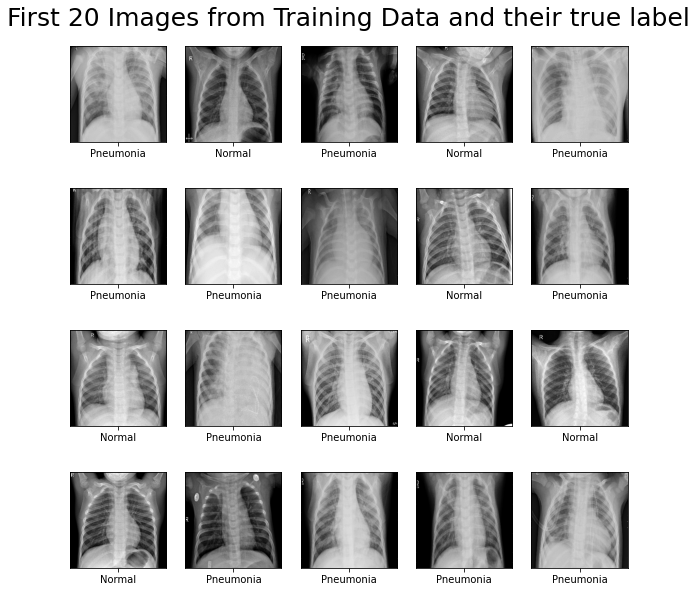

In [9]:
preview_first_20(train_img, train_labels, 'First 20 Images from Training Data and their true label')

# Validation data and Downsampled train set  
## Create the data
Due to the size of this dataset I will build models with a downsampled set. I want to keep the above training set intact so I can use it at the end of this notebook to train my final model. This means I will need to copy images into new folders. My downsampled train set will consist of 500 images from `train_norm` and 500 from `train_pneum`. I will also create a validation set of images not used in my downsampled train set of 25 NORMAL and 25 PNEUMONIA. 
 
WARNING: Before running below cell for the first time please scroll down and read comment box!

In [10]:
# new file paths
modeling_data_dir = 'data/CellData/chest_xray/modeling_data'
down_train_dir = os.path.join(modeling_data_dir, 'downsample_train')
down_norm_dir = os.path.join(down_train_dir, 'NORMAL')
down_pneum_dir = os.path.join(down_train_dir, 'PNEUMONIA')
val_dir = os.path.join(modeling_data_dir, 'valdation')
val_norm_dir = os.path.join(val_dir, 'NORMAL')
val_pneum_dir = os.path.join(val_dir, 'PNEUMONIA')

# check if folder already exist
if os.path.exists(modeling_data_dir): # check if folder already exist
    print('Data has already been downsampled and is ready for ImageDataGenerator.') 
    print('\tDownsampled training data directory is: down_train_dir')
    print('\t\tThere are 500 NORMAL images in this downsampled train set')
    print('\t\tThere are 500 PNEUMONIA images in this downsampled train set')
    print('\tValidation data directory is: val_dir')
    print('\t\tThere are 25 NORMAL images in the validation set')
    print('\t\tThere are 25 PNEUMONIA images in the validation set')
    
# if not, create new directories and divide data
else:
    # generate 500 random indices from train data 
    downsample_indices_norm = random.sample(range(0, len(train_norm)), 500)
    downsample_indices_pneum = random.sample(range(0, len(train_pneum)), 500)
    
    # generate 25 random indices from train data that are not in downsampled data
    val_indices_norm = []
    while len(val_indices_norm) < 25:
        index = random.randint(0, len(train_norm))
        if index not in downsample_indices_norm or val_indices_norm:
            val_indices_norm.append(index)
            
    val_indices_pneum = []
    while len(val_indices_pneum) < 25:
        index = random.randint(0, len(train_pneum))
        if index not in downsample_indices_pneum or val_indices_pneum:
            val_indices_pneum.append(index)
            
            
    ################################################################################
    # I am leaving the above code so you can see how I divided my data but I am    #
    # adding the 4 variables below to ensure the same images used for training     #
    # and validation are selected.                                                 #
    # To select your own random set simply hash out below 4 before running cell    #
    downsample_indices_norm = reuse_downsample_indices_norm                        #   
    downsample_indices_pneum = reuse_downsample_indices_pneum                      # 
    val_indices_norm = reuse_val_indices_norm                                      #
    val_indices_pneum = reuse_val_indices_pneum                                    #
    ################################################################################
    
    # selected images using the randomly generated indices
    train_down_norm = [train_norm[i] for i in downsample_indices_norm]
    train_down_pneum = [train_pneum[i] for i in downsample_indices_pneum]
    val_norm = [train_norm[i] for i in val_indices_norm]
    val_pneum = [train_pneum[i] for i in val_indices_pneum]
    
    # create new folders
    print('Creating new folders...')
    os.mkdir(modeling_data_dir)
    os.mkdir(down_train_dir)
    os.mkdir(down_norm_dir)
    os.mkdir(down_pneum_dir)
    os.mkdir(val_dir)
    os.mkdir(val_norm_dir)
    os.mkdir(val_pneum_dir)

    # copy images into new folders
    print('Copying images to new folders...')
    for img in train_down_norm:
        origin = os.path.join(train_dir_norm, img)
        destination = os.path.join(down_norm_dir, img)
        shutil.copyfile(origin, destination)
        
    for img in train_down_pneum:
        origin = os.path.join(train_dir_pneum, img)
        destination = os.path.join(down_pneum_dir, img)
        shutil.copyfile(origin, destination)
        
    for img in val_norm:
        origin = os.path.join(train_dir_norm, img)
        destination = os.path.join(val_norm_dir, img)
        shutil.copyfile(origin, destination)
    
    for img in val_pneum:
        origin = os.path.join(train_dir_pneum, img)
        destination = os.path.join(val_pneum_dir, img)
        shutil.copyfile(origin, destination)
    
    print('Data is now ready for ImageDataGenerator.')
    print('\tDownsampled training data directory is: down_train_dir')
    print('\t\tThere are', len(train_down_norm), 'NORMAL images in this downsampled train set')
    print('\t\tThere are', len(train_down_pneum), 'PNEUMONIA images in this downsampled train set')
    print('\tValidation data directory is: val_dir')
    print('\t\tThere are', len(val_norm), 'NORMAL images in the validation set')
    print('\t\tThere are', len(val_pneum), 'PNEUMONIA images in the validation set')

Data has already been downsampled and is ready for ImageDataGenerator.
	Downsampled training data directory is: down_train_dir
		There are 500 NORMAL images in this downsampled train set
		There are 500 PNEUMONIA images in this downsampled train set
	Validation data directory is: val_dir
		There are 25 NORMAL images in the validation set
		There are 25 PNEUMONIA images in the validation set


In [11]:
# get data, normalize, and reshape
train_downsampled_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(down_train_dir, 
                                                                                     color_mode="grayscale",
                                                                                     class_mode="binary",
                                                                                     batch_size=1000)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir,
                                                                       color_mode="grayscale",
                                                                       class_mode="binary",
                                                                       batch_size=50)

# create the data sets
down_images, down_labels = next(train_downsampled_generator)
val_images, val_labels = next(val_generator)

# reshape 
down_img = down_images.reshape(down_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

# check
print()
print("down_images shape: " + str(down_images.shape)) # before reshaping
print("down_img shape: " + str(down_img.shape))       # after reshaping
print("down_labels shape: " + str(down_labels.shape))
print()
print("val_images shape: " + str(val_images.shape)) # before reshaping
print("val_img shape: " + str(val_img.shape))       # after reshaping
print("val_labels shape: " + str(val_labels.shape))

Found 1000 images belonging to 2 classes.
Found 50 images belonging to 2 classes.

down_images shape: (1000, 256, 256, 1)
down_img shape: (1000, 65536)
down_labels shape: (1000,)

val_images shape: (50, 256, 256, 1)
val_img shape: (50, 65536)
val_labels shape: (50,)


## Preview 20 images from the downsampled training data

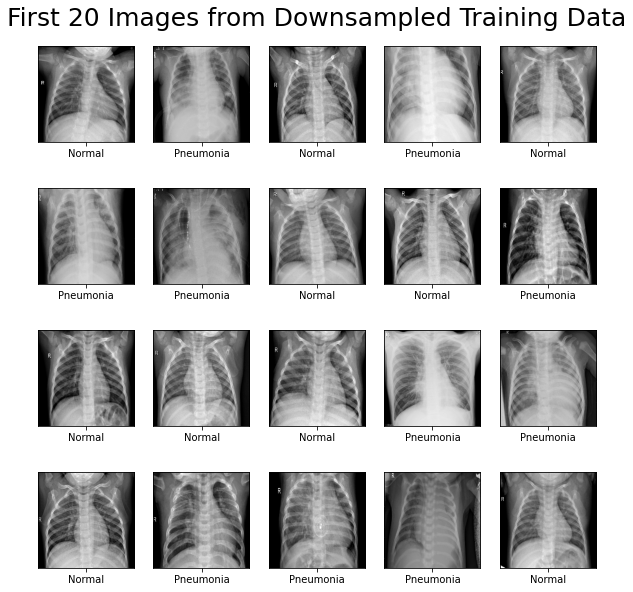

In [12]:
preview_first_20(down_img, down_labels, "First 20 Images from Downsampled Training Data")

# Training data - downsample downsampled data
I down sampled to 1000 images but as I started working through notebook it became obvious my laptop and it's cute little cpu is not enuough to process 1000 images in a reasonable amount of time. Fortuitously, images 7 - 507 are an even split of 250 PNEUMONIA and 250 NORMAL. I will keep my downsampled training set intact, incase I want to use it later, and assign new variables x_img, x_images, and y to use as this smaller set of training data to train models.

## Sum labels to count number of 1's (Pneumonia images)

In [13]:
start = 0
stop = 500
while sum(down_labels[start:stop]) != 250.0:
    start+=1
    stop+=1
    
print(f'down_labels[{start}:{stop}] is and even split of 250 PNEUMONIA and 250 NORMAL')

down_labels[7:507] is and even split of 250 PNEUMONIA and 250 NORMAL


## Confirm there are 500 images in this range

In [14]:
len(down_labels[start:stop])

500

## Assign x and y variables for reduced training set

In [15]:
x_img = down_img[start:stop]
x_images = down_images[start:stop]
y = down_labels[start:stop]

print(x_img.shape)
print(x_images.shape)
print(y.shape)

(500, 65536)
(500, 256, 256, 1)
(500,)


---
---
# Model Architecture

## Optimizers

SGD: "...recent studies show that Adam often leads to worse generalization performance than SGD for training deep neural networks on image classification tasks" [Adam vs. SGD: Closing the generalization gap on image classification](https://opt-ml.org/papers/2021/paper53.pdf).


## Activation Functions 

For hidden layers: ReLU, This is the standard activation function for hidden layers. There is no data to suggest deviating from this norm would be beneficial to this image classification task.

For output neron: Sigmoid, becuase this is a binary classification we can use sigmoid function to give probability of a given image being pneumonia. These probability predictions range from 0-1 making it easy to convert to percentages if so desired.  

## Padding 

For convolutional layers I will set padding equal to 'same'. This means there is one layer padding with blank pixels and the resulting pixels is the same size as the input image. It ensures that the filter is applied to all the elements of the input. Conversely, when padding is set to equal 'valid' there can be a loss of information, generally, elements on the right and the bottom of the image tend to be ignored. See below graphic from [this article](https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480):

padding='valid' is the first figure. The filter window stays inside the image.

padding='same' is the third figure. The output is the same size.

Visualization credits: [vdumoulin@GitHub](https://github.com/vdumoulin/conv_arithmetic)


<img src="https://i.stack.imgur.com/0rs9l.gif" alt="padding graphic" />



## Loss 

binary_crossentropy: This is a binary classification problem

## Metrics 

accuracy: I am using accuracy because I want a reliable model that does a good job at accurately labeling cases. However, false negatives are a much bigger issue that false positives so in addition to accuracy I will be focusing on pneumonia recall score from the classification report as a secondary metric for guaging model performance. And more specifically, I will be focusing on the difference between training recall scores and testing recall scores, they should be as similar as possible to show that the final model will reliably perform at the same level on new unseen data/cases as it did with the training data. 


---
---

# Create baseline fully connected model
## Build the layers and view model summary


In [16]:
# Build a baseline fully connected model without convolutional layers
base_model = models.Sequential()

base_model.add(layers.Dense(100, activation='relu', input_dim=x_img.shape[1])) 
base_model.add(layers.Dense(68, activation='relu'))
base_model.add(layers.Dense(30, activation='relu'))
base_model.add(layers.Dense(1, activation='sigmoid'))

base_model.compile(optimizer='SGD',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               6553700   
_________________________________________________________________
dense_1 (Dense)              (None, 68)                6868      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2070      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 6,562,669
Trainable params: 6,562,669
Non-trainable params: 0
_________________________________________________________________


## Define EarlyStopping object

In [17]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=1e-8,
                           verbose=0,
                           mode='min',
                           patience=10)

## Fit, or load the model and saved df, plot loss and accuracy over epochs

Would you like to bypass .fit and load saved base_model model? y/n: y
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               6553700   
_________________________________________________________________
dense_5 (Dense)              (None, 68)                6868      
_________________________________________________________________
dense_6 (Dense)              (None, 30)                2070      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 31        
Total params: 6,562,669
Trainable params: 6,562,669
Non-trainable params: 0
_________________________________________________________________
None


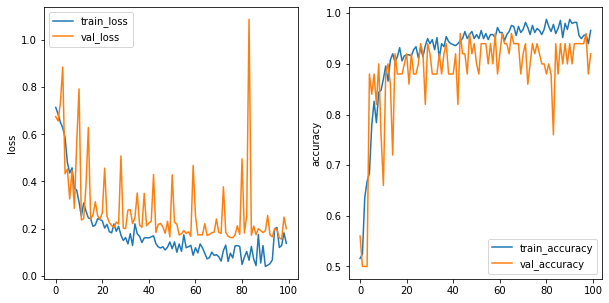

In [18]:
x = input("Would you like to bypass .fit and load saved base_model model? y/n: ")
all_y = ['y', 'yes']
if x.lower() in all_y:
    # load the saved model
    base_model = models.load_model('base_model.h5')
    # load the df with the loss and accuracy over epochs
    base_model_results_df = pd.read_pickle("./base_model_results_df.pkl") 
    # print the model summary, to for visual comparision to above
    print(base_model.summary())
    # plot the model loss and accuracy
    plot_loss_accuracy(base_model_results_df);

else:
    
    # fit model
    base_model_results = base_model.fit(x_img,
                                        y,
                                        epochs=100, # this model trains very quickly so I am putting up to 100
                                        batch_size=10,
                                        validation_data=(val_img, val_labels))
    # plot loss and accuracy
    plot_loss_accuracy((base_model_results.history));
    # save the model
    base_model.save('base_model.h5')
    # create df from base_model_results.history
    df = to_df(base_model_results.history)
    # save the dictionary from base_model_results
    pd.to_pickle(df, "./base_model_results_df.pkl")

## Loss and accuracy - training and test data

In [19]:
base_model_metrics_df = dot_evaluate_to_df('base_model', base_model, x_img, y, test_img, test_labels)
base_model_metrics_df

,train_loss,train_acc,test_loss,test_acc,loss_diff,acc_diff
base_model,0.040549,0.988,0.59899,0.849359,0.558442,0.138641


## Classification report and confusion matrix - training and test data

### Training

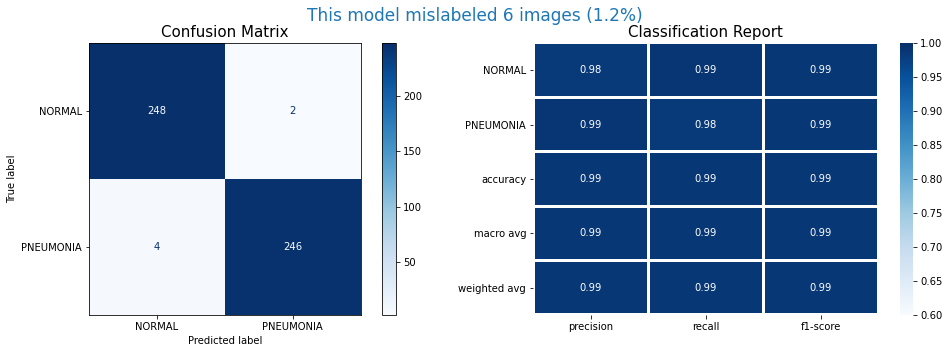

In [20]:
train_preds = base_model.predict(x_img, batch_size=10)

train_indices_of_incorrect_predictions = evaluate_model(x_img, y, train_preds)

### Test

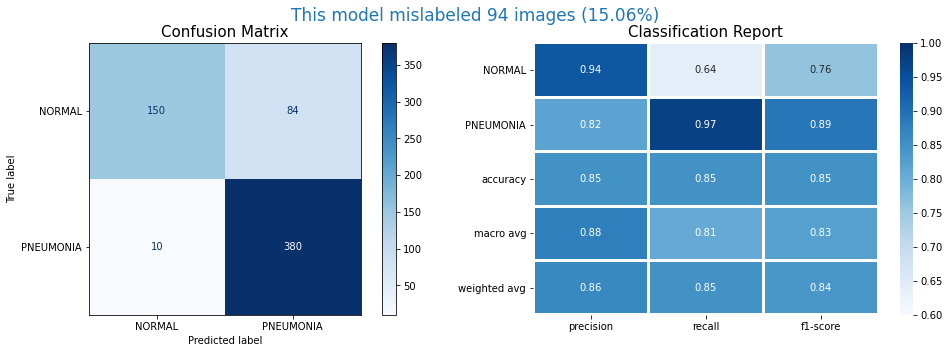

In [21]:
test_preds = base_model.predict(test_img)
indices_of_incorrect_predictions = evaluate_model(test_img, test_labels, test_preds)

## View misclassified images - training data
Below are the images the model misclassified as well as the models predicted probability of Pnemonia. This is to see if an adjustment in the .5 threshold could help the model capture more true positives. 

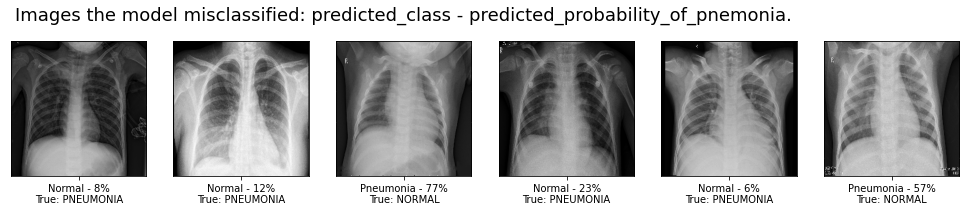

In [22]:
incorrect_images = [x_img[n] for n in train_indices_of_incorrect_predictions]
incorrect_true_labels = [y[n] for n in train_indices_of_incorrect_predictions]
convert_to_percent = [p*100 for p in train_preds]
predicted_proba = [round(list(convert_to_percent[i])[0]) for i in train_indices_of_incorrect_predictions]

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(17,5))
for n in range(len(incorrect_images)):
    #i = n //7
    #j = n%7
    ax = axes[n] #[i][j]
    ax.imshow(incorrect_images[n].reshape(256, 256), cmap=plt.cm.gray)
    ax.set_xticks([128])
    
    # if the true label is 0 (NORMAL) and model was incorrect then model predicted PNEUMONIA
    if incorrect_true_labels[n] == 0: 
        ax.set_xticklabels([f'Pneumonia - {int(predicted_proba[n])}%\nTrue: NORMAL'])
    # conversely, 
    else:
        ax.set_xticklabels([f'Normal - {int(predicted_proba[n])}%\nTrue: PNEUMONIA'])
    
    ax.set_yticks([])
    # tinker with this, either 2,3,4 to get title centered depending on number of columns
    if n == 2:
        ax.set_title("Images the model misclassified: predicted_class - predicted_probability_of_pnemonia.", 
                     fontsize=18, 
                     pad=20);
        

# Create baseline CNN model
## Add convolutional layers to `base_model`
Adding MaxPooling layers between convolutional layers:

MaxPooling: Calculate the maximum value for each patch of the feature map.
The result of using a pooling layer and creating down sampled or pooled feature maps is a summarized version of the features detected in the input. [A Gentle Introduction to Pooling Layers for Convolutional Neural Networks](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/)

In [23]:
base_cnn = models.Sequential()
base_cnn.add(layers.Conv2D(100, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 1)))
base_cnn.add(layers.MaxPooling2D((2, 2)))

base_cnn.add(layers.Conv2D(80, (3, 3), padding='same', activation='relu'))
base_cnn.add(layers.MaxPooling2D((2, 2)))

base_cnn.add(layers.Conv2D(70, (3, 3), padding='same', activation='relu'))
base_cnn.add(layers.MaxPooling2D((2, 2)))

base_cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
base_cnn.add(layers.MaxPooling2D((2, 2)))

base_cnn.add(layers.Flatten())

base_cnn.add(layers.Dense(100, activation='relu')) 
base_cnn.add(layers.Dense(68, activation='relu'))
base_cnn.add(layers.Dense(30, activation='relu'))
base_cnn.add(layers.Dense(1, activation='sigmoid'))

base_cnn.compile(optimizer='SGD',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

base_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 100)     1000      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 100)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 80)      72080     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 80)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 70)        50470     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 70)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)       

## Fit ,or load the model and saved df, plot loss and accuracy over epochs

Would you like to bypass .fit and load saved base_cnn model? y/n: y
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 100)     1000      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 100)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 80)      72080     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 80)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 70)        50470     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 70)        0         
____________________________________________________

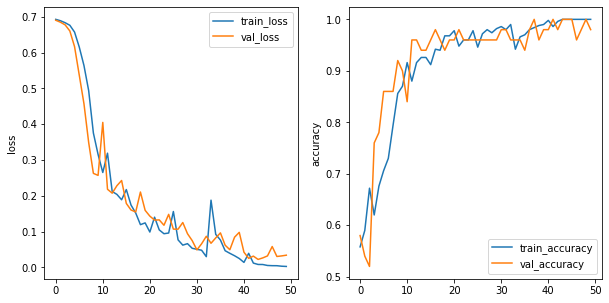

In [24]:
x = input("Would you like to bypass .fit and load saved base_cnn model? y/n: ")
all_y = ['y', 'yes']
if x.lower() in all_y:
    # load the saved model
    base_cnn = models.load_model('base_cnn.h5')
    # load the df with the loss and accuracy over epochs
    base_cnn_results_df = pd.read_pickle("./base_cnn_results_df.pkl") 
    # print the model summary, to for visual comparision to above
    print(base_cnn.summary())
    # plot the model loss and accuracy
    plot_loss_accuracy(base_cnn_results_df);

else:
    # fit model
    base_cnn_results = base_cnn.fit(x_images,
                                    y,
                                    epochs=50,
                                    batch_size=10,
                                    callbacks=[early_stop],
                                    validation_data=(val_images, val_labels))
    
    # plot loss and accuracy
    plot_loss_accuracy((base_cnn_results.history));
    # save the model
    base_cnn.save('base_cnn.h5')
    # create df from base_cnn_results.history
    df = to_df(base_cnn_results.history)
    # save the dictionary from base_cnn_results
    pd.to_pickle(df, "./base_cnn_results_df.pkl")

## Loss and accuracy - training and test data
I will join `base_model_metrics_df` and `base_cnn_metrics_df` to start a `metrics_df`

In [25]:
base_cnn_metrics_df = dot_evaluate_to_df('base_cnn', base_cnn, x_images, y, test_images, test_labels)
metrics_df = pd.concat([base_model_metrics_df, base_cnn_metrics_df])
metrics_df

,train_loss,train_acc,test_loss,test_acc,loss_diff,acc_diff
base_model,0.040549,0.988,0.598990,0.849359,0.558442,0.138641
base_cnn,0.001954,1.000,0.899908,0.868590,0.897954,0.131410


## Classification report and confusion matrix - training and test data

### Training

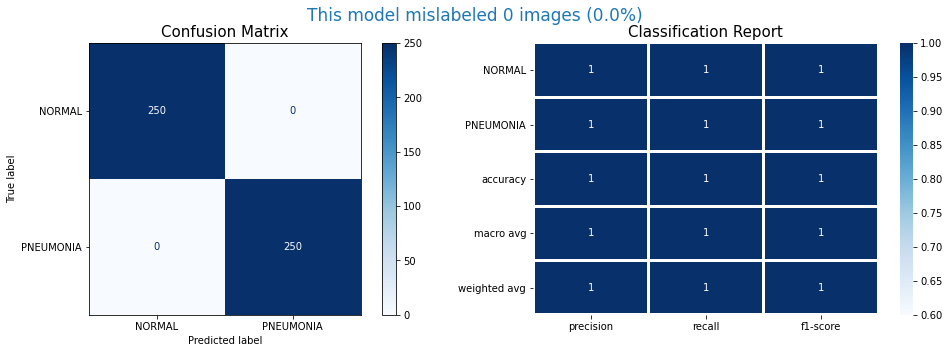

In [26]:
train_preds = base_cnn.predict(x_images, batch_size=10)
cnn_train_indices_of_incorrect_predictions = evaluate_model(x_images, y, train_preds)

### Test

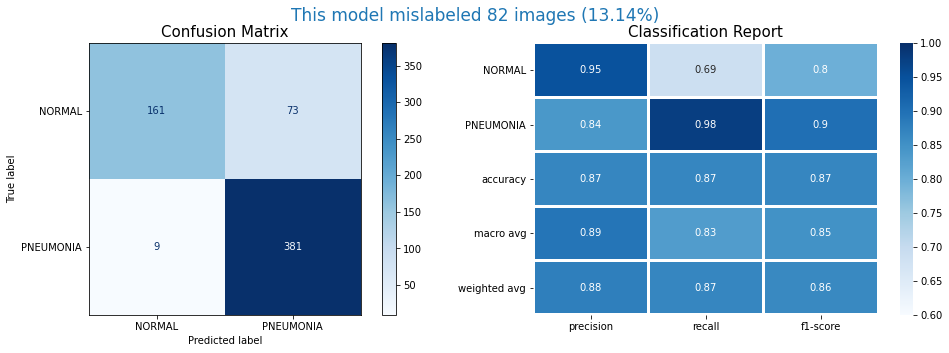

In [27]:
test_preds = base_cnn.predict(test_images)
cnn_test_indices_of_incorrect_predictions = evaluate_model(test_images, test_labels, test_preds)

## Compare two models

In [28]:
convert_base_model = {'base_train': {'pneumonia_recall': .98, 'misclassified': .01, 'accuracy':.99},
                      'base_test': {'pneumonia_recall': .97, 'misclassified': .15, 'accuracy':.85}}

convert_base_cnn  = {'cnn_train': {'pneumonia_recall': 1, 'misclassified': 0, 'accuracy':1},
                      'cnn_test': {'pneumonia_recall': .98, 'misclassified': .131, 'accuracy':.87}}

compare = pd.concat([pd.DataFrame(convert_base_model),pd.DataFrame(convert_base_cnn)], axis=1).T
compare

,pneumonia_recall,misclassified,accuracy
base_train,0.98,0.010,0.99
base_test,0.97,0.150,0.85
cnn_train,1.00,0.000,1.00
cnn_test,0.98,0.131,0.87


# Add kernel regularization to `base_cnn` model
There is still a slight over fitting so I will try applying an l2 regularization with a lambda coefficient of .005.

Performing L2 regularization encourages the weight values towards zero (but not exactly zero). Smaller weights reduce the impact of the hidden neurons. In that case, those hidden neurons become neglectable and the overall complexity of the neural network gets reduced, less complex models typically avoid modeling noise in the data, and therefore, there is no overfitting. 

Choosing the right lambda coeffient value:
- If value is too high you run the risk of underfitting your data. Your model won’t learn enough about the training data to make useful predictions.
- If value is too low you run the risk of overfitting your data. Your model will learn too much about the particularities of the training data, and won’t be able to generalize to new data.

## Add to each fully connected hidden layer

In [29]:
reg_cnn = models.Sequential()
reg_cnn.add(layers.Conv2D(100, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 1)))
reg_cnn.add(layers.MaxPooling2D((2, 2)))

reg_cnn.add(layers.Conv2D(80, (3, 3), padding='same', activation='relu'))
reg_cnn.add(layers.MaxPooling2D((2, 2)))

reg_cnn.add(layers.Conv2D(70, (3, 3), padding='same', activation='relu'))
reg_cnn.add(layers.MaxPooling2D((2, 2)))

reg_cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
reg_cnn.add(layers.MaxPooling2D((2, 2)))

reg_cnn.add(layers.Flatten())

reg_cnn.add(layers.Dense(100, kernel_regularizer=regularizers.l2(.005), activation='relu')) 
reg_cnn.add(layers.Dense(68, kernel_regularizer=regularizers.l2(.005),activation='relu'))
reg_cnn.add(layers.Dense(30, kernel_regularizer=regularizers.l2(.005),activation='relu'))
reg_cnn.add(layers.Dense(1, activation='sigmoid'))

reg_cnn.compile(optimizer='SGD',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

reg_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 100)     1000      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 100)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 80)      72080     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 80)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 70)        50470     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 70)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)       

## Fit, or load the model and saved df, plot loss and accuracy over epochs

Would you like to bypass .fit and load saved reg_cnn model? y/n: y
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 100)     1000      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 100)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 80)      72080     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 80)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 70)        50470     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 70)        0         
_____________________________________________________

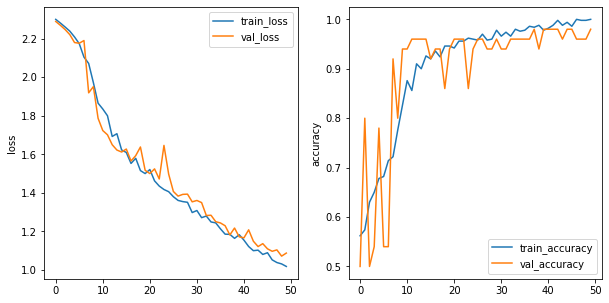

In [30]:
x = input("Would you like to bypass .fit and load saved reg_cnn model? y/n: ")
all_y = ['y', 'yes']
if x.lower() in all_y:
    # load the saved model
    reg_cnn = models.load_model('reg_cnn.h5')
    # load the df with the loss and accuracy over epochs
    reg_cnn_results_df = pd.read_pickle("./reg_cnn_results_df.pkl") 
    # print the model summary, to for visual comparision to above
    print(reg_cnn.summary())
    # plot the model loss and accuracy
    plot_loss_accuracy(reg_cnn_results_df);

else:
    # fit model
    reg_cnn_results = reg_cnn.fit(x_images,
                                    y,
                                    epochs=50,
                                    batch_size=10,
                                    callbacks=[early_stop],
                                    validation_data=(val_images, val_labels))
    
    # plot loss and accuracy
    plot_loss_accuracy((reg_cnn_results.history));
    # save the model
    reg_cnn.save('reg_cnn.h5')
    # create df from reg_cnn_results.history
    df = to_df(reg_cnn_results.history)
    # save the dictionary from reg_cnn_results
    pd.to_pickle(df, "./reg_cnn_results_df.pkl")

## Loss and accuracy - training and test data

In [31]:
reg_cnn_metrics_df = dot_evaluate_to_df('reg_cnn', reg_cnn, x_images, y, test_images, test_labels)
metrics_df = pd.concat([metrics_df, reg_cnn_metrics_df])
metrics_df

,train_loss,train_acc,test_loss,test_acc,loss_diff,acc_diff
base_model,0.040549,0.988,0.598990,0.849359,0.558442,0.138641
base_cnn,0.001954,1.000,0.899908,0.868590,0.897954,0.131410
reg_cnn,1.012247,1.000,1.839380,0.862179,0.827133,0.137821


## Classification report and confusion matrix - training and test data
### Train

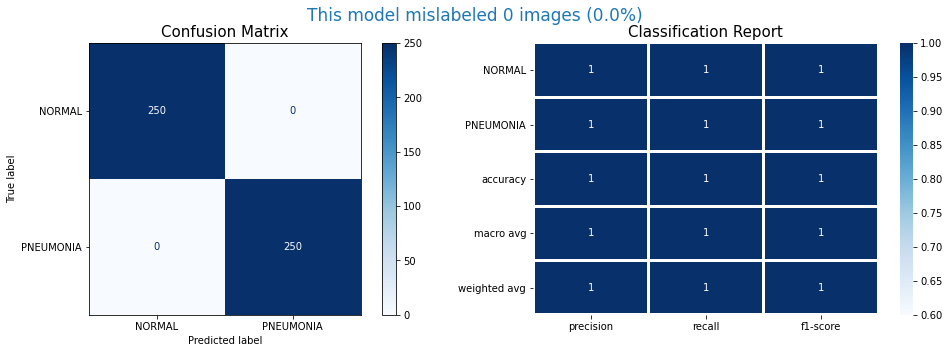

In [32]:
train_preds = reg_cnn.predict(x_images, batch_size=10)
reg_train_indices_of_incorrect_predictions = evaluate_model(x_images, y, train_preds)

### Test

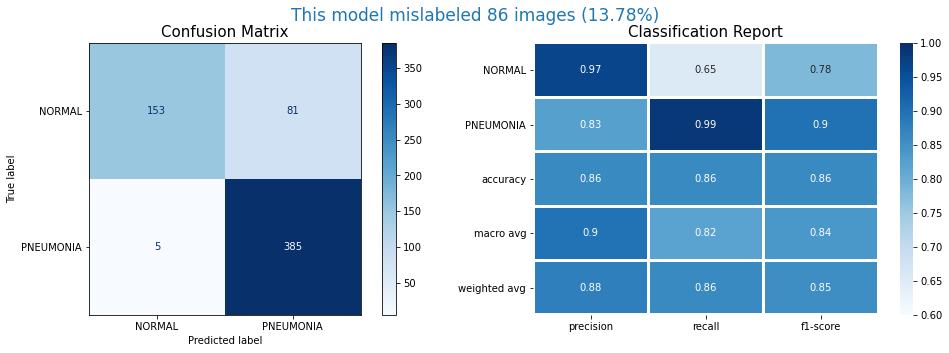

In [33]:
test_preds = reg_cnn.predict(test_images)
reg_test_indices_of_incorrect_predictions = evaluate_model(test_images, test_labels, test_preds)

## Compare the models

In [34]:
convert_reg_cnn  = {'reg_train': {'pneumonia_recall': 1, 'misclassified': 0, 'accuracy':1},
                    'reg_test': {'pneumonia_recall': .99, 'misclassified': .139, 'accuracy':.86}}

add_this = pd.DataFrame(convert_reg_cnn).T


compare = pd.concat([compare, add_this])
compare

,pneumonia_recall,misclassified,accuracy
base_train,0.98,0.010,0.99
base_test,0.97,0.150,0.85
cnn_train,1.00,0.000,1.00
cnn_test,0.98,0.131,0.87
reg_train,1.00,0.000,1.00
reg_test,0.99,0.139,0.86


In [35]:
# just the test data
compare.loc[['base_test', 'cnn_test', 'reg_test']]

,pneumonia_recall,misclassified,accuracy
base_test,0.97,0.150,0.85
cnn_test,0.98,0.131,0.87
reg_test,0.99,0.139,0.86


# Reduce nodes
Accuracy between training and validation sets are just a few percentages off. I'd like to see if reducing the number of nodes can close that gap even just a percent or two before I train the model on the larger training set overnight. 
## Cut number of nodes in half at each layer except output

In [36]:
reduced_nodes = models.Sequential()
reduced_nodes.add(layers.Conv2D(50, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 1)))
reduced_nodes.add(layers.MaxPooling2D((2, 2)))

reduced_nodes.add(layers.Conv2D(40, (3, 3), padding='same', activation='relu'))
reduced_nodes.add(layers.MaxPooling2D((2, 2)))

reduced_nodes.add(layers.Conv2D(35, (3, 3), padding='same', activation='relu'))
reduced_nodes.add(layers.MaxPooling2D((2, 2)))

reduced_nodes.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
reduced_nodes.add(layers.MaxPooling2D((2, 2)))

reduced_nodes.add(layers.Flatten())

reduced_nodes.add(layers.Dense(50, kernel_regularizer=regularizers.l2(.005), activation='relu')) 
reduced_nodes.add(layers.Dense(34, kernel_regularizer=regularizers.l2(.005),activation='relu'))
reduced_nodes.add(layers.Dense(15, kernel_regularizer=regularizers.l2(.005),activation='relu'))
reduced_nodes.add(layers.Dense(1, activation='sigmoid'))

reduced_nodes.compile(optimizer='SGD',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

reduced_nodes.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 256, 256, 50)      500       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 50)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 40)      18040     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 40)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 35)        12635     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 35)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)       

## Fit, or load the model and saved df, plot loss and accuracy over epochs

Would you like to bypass .fit and load saved reduced_nodes model? y/n: y
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 256, 256, 50)      500       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 50)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 40)      18040     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 40)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 35)        12635     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 35)        0         
_______________________________________________

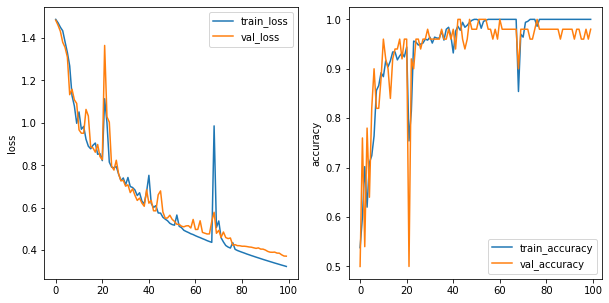

In [37]:
x = input("Would you like to bypass .fit and load saved reduced_nodes model? y/n: ")
all_y = ['y', 'yes']
if x.lower() in all_y:
    # load the saved model
    reduced_nodes = models.load_model('reduced_nodes.h5')
    # load the df with the loss and accuracy over epochs
    reduced_nodes_results_df = pd.read_pickle("./reduced_nodes_results_df.pkl") 
    # print the model summary, to for visual comparision to above
    print(reduced_nodes.summary())
    # plot the model loss and accuracy
    plot_loss_accuracy(reduced_nodes_results_df);

else:
    # fit model
    reduced_nodes_results = reduced_nodes.fit(x_images,
                                              y,
                                              epochs=100, # this trains a little quicker so increasing epochs
                                              batch_size=10,
                                              callbacks=[early_stop],
                                              validation_data=(val_images, val_labels))
    
    # plot loss and accuracy
    plot_loss_accuracy((reduced_nodes_results.history));
    # save the model
    reduced_nodes.save('reduced_nodes.h5')
    # create df from reduced_nodes_results.history
    df = to_df(reduced_nodes_results.history)
    # save the dictionary from reduced_nodes_results
    pd.to_pickle(df, "./reduced_nodes_results_df.pkl")

## Loss and accuracy - training and test data

In [38]:
reduced_nodes_metrics_df = dot_evaluate_to_df('reduced_nodes', reduced_nodes, x_images, y, test_images, test_labels)
metrics_df = pd.concat([metrics_df, reduced_nodes_metrics_df])
metrics_df

,train_loss,train_acc,test_loss,test_acc,loss_diff,acc_diff
base_model,0.040549,0.988,0.598990,0.849359,0.558442,0.138641
base_cnn,0.001954,1.000,0.899908,0.868590,0.897954,0.131410
reg_cnn,1.012247,1.000,1.839380,0.862179,0.827133,0.137821
reduced_nodes,0.321644,1.000,1.059986,0.875000,0.738342,0.125000


## Classification report and confusion matrix - training and test data
### Train

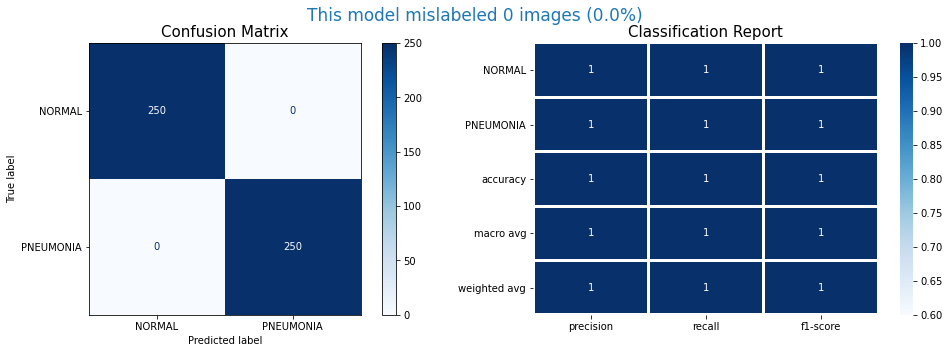

In [39]:
train_preds = reduced_nodes.predict(x_images, batch_size=10)
reduced_train_indices_of_incorrect_predictions = evaluate_model(x_images, y, train_preds)

### Test

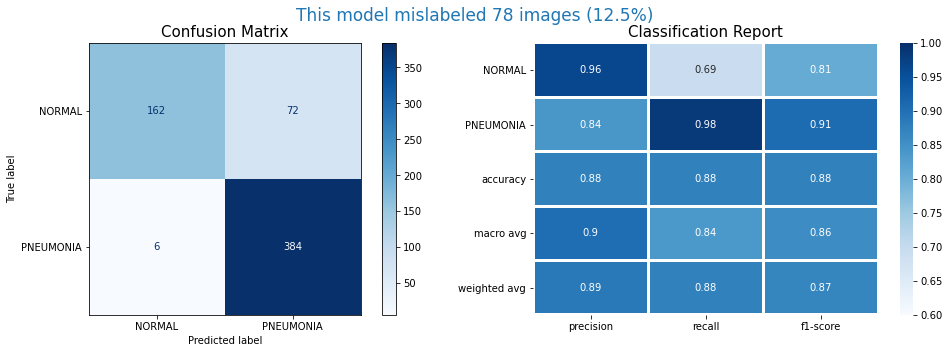

In [40]:
test_preds = reduced_nodes.predict(test_images)
reduced_test_indices_of_incorrect_predictions = evaluate_model(test_images, test_labels, test_preds)

## Compare the models

In [41]:
convert_reduced  = {'reduced_train': {'pneumonia_recall': 1, 'misclassified': 0, 'accuracy':1},
                    'reduced_test': {'pneumonia_recall': .98, 'misclassified': .125, 'accuracy':.88}}

add_this = pd.DataFrame(convert_reduced).T


compare = pd.concat([compare, add_this])
compare

,pneumonia_recall,misclassified,accuracy
base_train,0.98,0.010,0.99
base_test,0.97,0.150,0.85
cnn_train,1.00,0.000,1.00
cnn_test,0.98,0.131,0.87
reg_train,1.00,0.000,1.00
reg_test,0.99,0.139,0.86
reduced_train,1.00,0.000,1.00
reduced_test,0.98,0.125,0.88


And a reminded of the `metrics_df`

In [42]:
metrics_df

,train_loss,train_acc,test_loss,test_acc,loss_diff,acc_diff
base_model,0.040549,0.988,0.598990,0.849359,0.558442,0.138641
base_cnn,0.001954,1.000,0.899908,0.868590,0.897954,0.131410
reg_cnn,1.012247,1.000,1.839380,0.862179,0.827133,0.137821
reduced_nodes,0.321644,1.000,1.059986,0.875000,0.738342,0.125000


In this `metrics_df` notice: `loss_diff` and `acc_diff` (the difference between loss and accuracy between train and test data). 
- `acc_diff` is lowest with this `reduced_nodes` model but 
- `loss_diff` is still higher than the `base_model`. 

In the `compare` df notice each model's progression has slightly increase model accuracy. However, in this latter iteration, the pneumonia recall score has dropped 1% from the prior model, and is only 1% higher than the `base_model`. 

At this point I feel this model is still slightly overfit and I would like to try and close the gap between the training and test loss difference and train and test accuracy difference. To do this I can try any of the following:
- remove layers
- include dropout
- reduce nodes further
- increase lambda coefficient

For my next model I will add dropout then I will have to move on to selecting a final model. 

# Add dropout to `reduced_nodes` model
During dropout, some neurons get deactivated with a random probability P to reduce model complexity resulting in less overfitting. I am using P=.03
## Add dropout to each fully connected hidden layer

In [43]:
dropout = models.Sequential()

dropout.add(layers.Conv2D(50, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 1)))
dropout.add(layers.MaxPooling2D((2, 2)))

dropout.add(layers.Conv2D(40, (3, 3), padding='same', activation='relu'))
dropout.add(layers.MaxPooling2D((2, 2)))

dropout.add(layers.Conv2D(35, (3, 3), padding='same', activation='relu'))
dropout.add(layers.MaxPooling2D((2, 2)))

dropout.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
dropout.add(layers.MaxPooling2D((2, 2)))

dropout.add(layers.Flatten())

dropout.add(layers.Dropout(0.3))
dropout.add(layers.Dense(50, kernel_regularizer=regularizers.l2(.005), activation='relu')) 
dropout.add(layers.Dropout(0.3))
dropout.add(layers.Dense(34, kernel_regularizer=regularizers.l2(.005),activation='relu'))
dropout.add(layers.Dropout(0.3))
dropout.add(layers.Dense(15, kernel_regularizer=regularizers.l2(.005),activation='relu'))
dropout.add(layers.Dropout(0.3))
dropout.add(layers.Dense(1, activation='sigmoid'))

dropout.compile(optimizer='SGD',
                loss='binary_crossentropy',
                metrics=['accuracy'])

dropout.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 256, 256, 50)      500       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 128, 128, 50)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 40)      18040     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 40)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 35)        12635     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 35)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 32)       

## Fit, or load the model and saved df, plot loss and accuracy over epochs

Would you like to bypass .fit and load saved dropout model? y/n: y
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 256, 256, 50)      500       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 128, 128, 50)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 40)      18040     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 40)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 35)        12635     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 35)        0         
_____________________________________________________

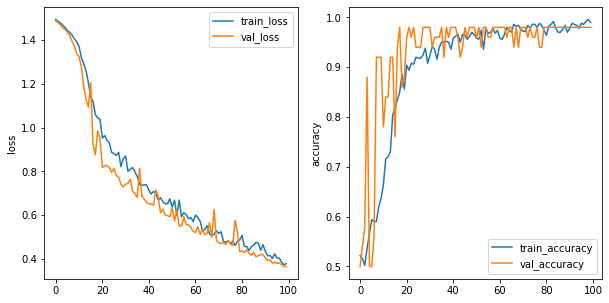

In [44]:
x = input("Would you like to bypass .fit and load saved dropout model? y/n: ")
all_y = ['y', 'yes']
if x.lower() in all_y:
    # load the saved model
    dropout = models.load_model('dropout.h5')
    # load the df with the loss and accuracy over epochs
    dropout_results_df = pd.read_pickle("./dropout_results_df.pkl") 
    # print the model summary, to for visual comparision to above
    print(dropout.summary())
    # plot the model loss and accuracy
    plot_loss_accuracy(dropout_results_df);

else:
    # fit model
    dropout_results = dropout.fit(x_images,
                                  y,
                                  epochs=100, # keeping epochs up
                                  batch_size=10,
                                  callbacks=[early_stop],
                                  validation_data=(val_images, val_labels))
    
    # plot loss and accuracy
    plot_loss_accuracy((dropout_results.history));
    # save the model
    dropout.save('dropout.h5')
    # create df from dropout_results.history
    df = to_df(dropout_results.history)
    # save the dictionary from dropout_results
    pd.to_pickle(df, "./dropout_results_df.pkl")

## Loss and accuracy - training and test data

In [45]:
dropout_metrics_df = dot_evaluate_to_df('dropout', dropout, x_images, y, test_images, test_labels)
metrics_df = pd.concat([metrics_df, dropout_metrics_df])
metrics_df

,train_loss,train_acc,test_loss,test_acc,loss_diff,acc_diff
base_model,0.040549,0.988,0.598990,0.849359,0.558442,0.138641
base_cnn,0.001954,1.000,0.899908,0.868590,0.897954,0.131410
reg_cnn,1.012247,1.000,1.839380,0.862179,0.827133,0.137821
reduced_nodes,0.321644,1.000,1.059986,0.875000,0.738342,0.125000
dropout,0.348353,0.998,0.967050,0.892628,0.618697,0.105372


## Classification report and confusion matrix - training and test data
### Train

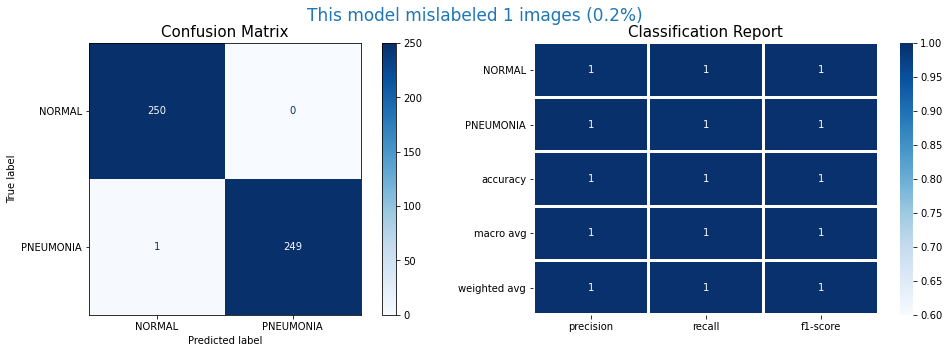

In [46]:
train_preds = dropout.predict(x_images, batch_size=10)
dropout_train_indices_of_incorrect_predictions = evaluate_model(x_images, y, train_preds)

### Test

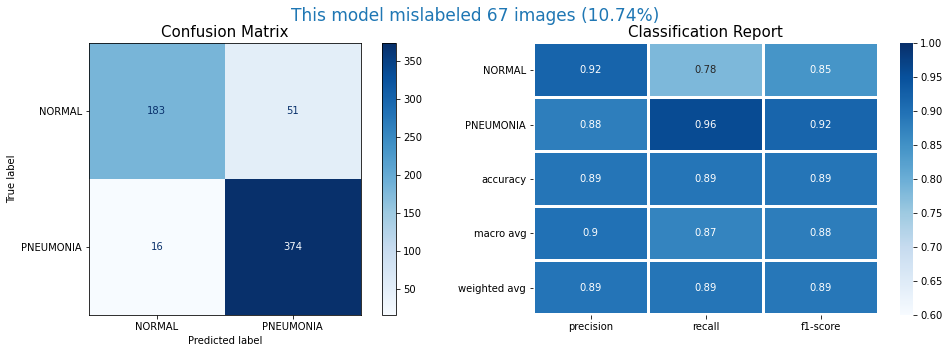

In [47]:
test_preds = dropout.predict(test_images)
dropout_test_indices_of_incorrect_predictions = evaluate_model(test_images, test_labels, test_preds)

## Compare the models

In [48]:
convert_dropout  = {'drop_train': {'pneumonia_recall': 1, 'misclassified': .002, 'accuracy':1},
                    'drop_test': {'pneumonia_recall': .96, 'misclassified': .107, 'accuracy':.89}}

add_this = pd.DataFrame(convert_dropout).T


compare = pd.concat([compare, add_this])
compare

,pneumonia_recall,misclassified,accuracy
base_train,0.98,0.010,0.99
base_test,0.97,0.150,0.85
cnn_train,1.00,0.000,1.00
cnn_test,0.98,0.131,0.87
reg_train,1.00,0.000,1.00
reg_test,0.99,0.139,0.86
reduced_train,1.00,0.000,1.00
reduced_test,0.98,0.125,0.88
drop_train,1.00,0.002,1.00
drop_test,0.96,0.107,0.89


And a reminder of the `metrics_df`

In [49]:
metrics_df

,train_loss,train_acc,test_loss,test_acc,loss_diff,acc_diff
base_model,0.040549,0.988,0.598990,0.849359,0.558442,0.138641
base_cnn,0.001954,1.000,0.899908,0.868590,0.897954,0.131410
reg_cnn,1.012247,1.000,1.839380,0.862179,0.827133,0.137821
reduced_nodes,0.321644,1.000,1.059986,0.875000,0.738342,0.125000
dropout,0.348353,0.998,0.967050,0.892628,0.618697,0.105372


My goal for adding dropout was to close the gap between the train and test loss difference and train and test accuracy difference. The `metrics_df` shows that this `dropout` model did infact reduce that gap from the previous model iteration. However, the `compare` df shows that while the accuracy improved with this `dropout` model, the pneumonia recall score for test data dropped. You can also explore this in greater detail by comparing the confusion matrices and classification reports from the test data from the last two models. 

At this point I need to move forward with selecting a final model. I can chose the higher accuracy `dropout` model, or the higher recall score of `reduced_nodes` model.

Because the intent of this model is to flag cases of concern, I will go with the higher recall score model, `reduced_nodes`, so that fewer cases are given a false negative label of NORMAL. This may result in increased number of cases prioritized for immediate review from radiologists however, I will capture as many true pneumonia cases as possible which in the end will result in expidited treatment for these patients. 

# FINAL MODEL TRAINING
For the above mentioned reasons I have chosen my final model to be the `reduced_nodes` model. 

## A review of the training data distribution

,label,count,percentage
0,NORMAL,1349,25.78%
1,PNEUMONIA,3883,74.22%


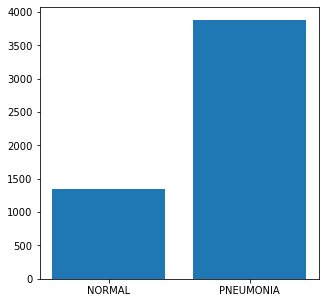

In [50]:
# convert 0 & 1 to NORMAL & PNEUMONIA 
better_plot = []
for label in train_labels:
    if label == 0.:
        better_plot.append('NORMAL')
    else:
        better_plot.append('PNEUMONIA')

# normalize the value counts         
normalized_pneumonia = sum(train_labels)/len(train_labels)
normalized_normal = 1 - normalized_pneumonia

# make a plotting df 
# convert string labels to df
bar_df = pd.DataFrame(better_plot, columns=['label']) 
# groupby classes (labels) and count them
count_df = pd.DataFrame(bar_df.groupby(['label'])['label'].count()) 
# change column from 'label' to 'count' then reset the index
plot_df = count_df.rename(columns={'label': 'count'}).reset_index() 

# add the percentages to df  
plot_df['percentage'] = [f'{round(100*normalized_normal,2)}%', f'{round(100*normalized_pneumonia,2)}%']

# display df for numeric distribution of classes  
display(plot_df)

# plot for visual distribution of classes
fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(plot_df['label'], plot_df['count']);

## Preparing the data
1. For the final model I chose to downsample the pneumonia class to match that of the normal class. This will bring the total number of training images to 2698 with an even split of both classes. I am going to do this in a different way than I did above. 
 - 12b - 1a. Downsample PNEUMONIA class to 1349 images:
    - First I will make a df of the class labels then filter to get just the pnemonia class, 
    - then convert those indices to a list, 
    - then form that list I will randomly select 1349 indices,
    - then use those reandomly selected indices to get images and labels of 1349 randomly selected pneumonia images. 
    - zip the image and labels together as a tuple

 - 12b - 1b. Merging NORMAL and downsampled PNEUMONIA classes 
    - filter to get just the normal class
    - convert those indices to a list
    - use those indices to get images and lables of normal class
    - zip the images and labels together 
    - join the two classes them suffle and unzip lables from images


2. Create a new validation set.  

3. Change type for newly created variables

###  Bring the total number of training images to 2698 with an even split of both classes
**Downsample PNEUMONIA class to 1349 images**

In [51]:
# get just the pneumonia class indices from train_labels
# convert train_labels to a df
class_df = pd.DataFrame(train_labels, columns=['class'])\
# filter to get just pneumonia class then .index to get indices
pi = class_df[class_df['class']==1].index
# convert pi (pneumonia indices) to a list
pi = list(pi)

In [52]:
# set a random seed for replicability
random.seed(1349)
# create new_X from these pneumonia indices 
new_X_indices = []
while len(new_X_indices) < 1349:
    index = random.choice(pi)
    if index not in new_X_indices:
        new_X_indices.append(index)

# check the length is 1349        
len(new_X_indices)

1349

In [53]:
# and a double check that there are no duplicates
len(set(new_X_indices))

1349

In [54]:
# make list of images using new_X_indices
p_images = [train_images[i] for i in new_X_indices]
# make list of lables using new_X_indices
p_labels = [train_labels[i] for i in new_X_indices]
# one more check to make sure all labels/images are pneumonia
print(sum(p_labels))
# and a check of shape
p_images[0].shape

1349.0


(256, 256, 1)

In [55]:
# zip images to lables
p_tup = list(zip(p_images, p_labels))

# visual check of the first one, should be: (image_array, label)
p_tup[0]

(array([[[0.08627451],
         [0.1137255 ],
         [0.13333334],
         ...,
         [0.03137255],
         [0.97647065],
         [0.01960784]],
 
        [[0.06666667],
         [0.08627451],
         [0.11764707],
         ...,
         [0.00784314],
         [0.98823535],
         [0.03921569]],
 
        [[0.05882353],
         [0.09411766],
         [0.12941177],
         ...,
         [0.05490196],
         [0.        ],
         [0.        ]],
 
        ...,
 
        [[0.00784314],
         [0.00784314],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],
 
        [[0.03137255],
         [1.        ],
         [0.03529412],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],
 
        [[0.05490196],
         [0.00392157],
         [0.05490196],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]], dtype=float32),
 1.0)

**Merging NORMAL and downsampled PNEUMONIA classes**

In [56]:
# get the normal indices
ni = class_df[class_df['class']==0].index
ni = list(ni)
n_images = [train_images[i] for i in ni]
n_labels = [train_labels[i] for i in ni]

# check they are all zeros/normal
print(sum(n_labels))

0.0


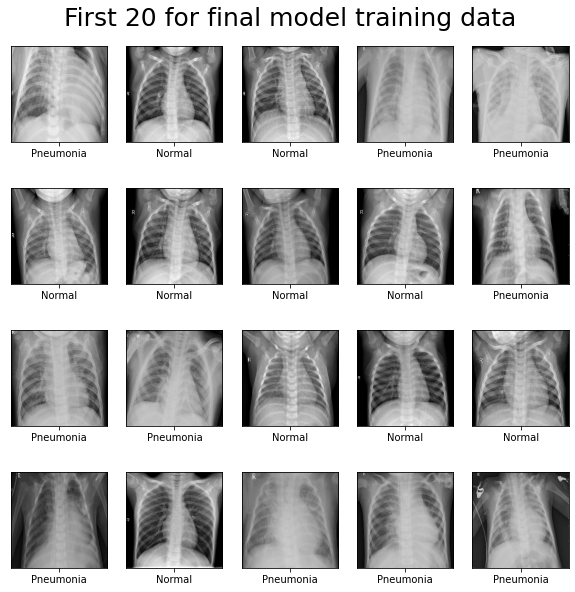

In [57]:
# zip images to lables
n_tup = list(zip(n_images, n_labels))

# combine normal and pneumonia data
n_plus_p = n_tup + p_tup

# shuffle so randomly distributed
random.seed(11616125)
n_plus_p = random.sample(n_plus_p, len(n_plus_p))

# seperate images from lables
images_labels = list(zip(*n_plus_p))
just_images = images_labels[0]
just_labels = images_labels[1]

# check
preview_first_20(just_images, just_labels, 'First 20 for final model training data')

### Creata a validation set

In [58]:
# use same method in step 8.1 to select validation data 
start = 0
stop = 50
while sum(just_labels[start:stop]) != 25.0:
    start+=1
    stop+=1
    
print(f'just_labels[{start}:{stop}] is and even split of 25 PNEUMONIA and 25 NORMAL')

just_labels[71:121] is and even split of 25 PNEUMONIA and 25 NORMAL


In [60]:
# assign variables
X_val = just_images[start:stop]
y_val = just_labels[start:stop]
X_train = just_images[:start]+just_images[stop:]
y_train = just_labels[:start]+just_labels[stop:]

# check 
print(f'length of X_train: {len(X_train)}')
print(f'length of X_val: {len(X_val)}')
print(f'length combined: {len(X_val) + len(X_train)}')

length of X_train: 2648
length of X_val: 50
length combined: 2698


### Change type of newly created variables

In [61]:
# check the type, when zipped together they became tuples
print(type(X_val))
print(type(y_val))
print(type(X_train))
print(type(y_train))

<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>


In [62]:
# change all back to arrays in order to fit data to model
X_val = np.array(X_val)
y_val = np.array(y_val)
X_train = np.array(X_train)
y_train = np.array(y_train)

In [63]:
# confirm change
print(type(X_val))
print(type(y_val))
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [64]:
# confirm shape has remained intact
X_train.shape

(2648, 256, 256, 1)

## Define the final models architecture 

In [65]:
final_model = models.Sequential()
final_model.add(layers.Conv2D(50, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 1)))
final_model.add(layers.MaxPooling2D((2, 2)))

final_model.add(layers.Conv2D(40, (3, 3), padding='same', activation='relu'))
final_model.add(layers.MaxPooling2D((2, 2)))

final_model.add(layers.Conv2D(35, (3, 3), padding='same', activation='relu'))
final_model.add(layers.MaxPooling2D((2, 2)))

final_model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
final_model.add(layers.MaxPooling2D((2, 2)))

final_model.add(layers.Flatten())

final_model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(.005), activation='relu')) 
final_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(.005),activation='relu'))
final_model.add(layers.Dense(5, kernel_regularizer=regularizers.l2(.005),activation='relu'))
final_model.add(layers.Dense(1, activation='sigmoid'))

final_model.compile(optimizer='SGD',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

final_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 256, 256, 50)      500       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 128, 128, 50)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 128, 128, 40)      18040     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 64, 64, 40)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 64, 35)        12635     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 32, 32, 35)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)       

## Fit, or load the model and saved df, plot loss and accuracy over epochs

Would you like to bypass .fit and load saved final_model model? y/n: y
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 256, 256, 50)      500       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 128, 128, 50)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 40)      18040     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 64, 64, 40)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 35)        12635     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 32, 32, 35)        0         
_________________________________________________

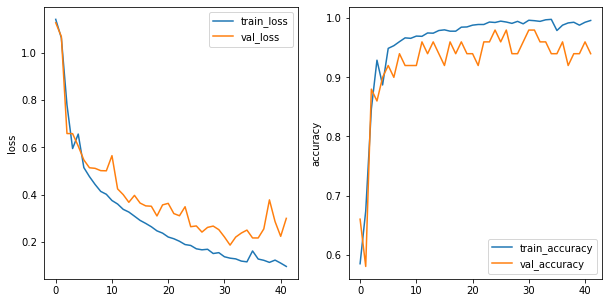

In [66]:
x = input("Would you like to bypass .fit and load saved final_model model? y/n: ")
all_y = ['y', 'yes']
if x.lower() in all_y:
    # load the saved model
    final_model = models.load_model('final_model.h5')
    # load the df with the loss and accuracy over epochs
    final_model_results_df = pd.read_pickle("./final_model_results_df.pkl") 
    # print the model summary, to for visual comparision to above
    print(final_model.summary())
    # plot the model loss and accuracy
    plot_loss_accuracy(final_model_results_df);

else:
    # fit model
    final_model_results = final_model.fit(X_train, 
                                          y_train,
                                          epochs=200, 
                                          batch_size=10,
                                          callbacks=[early_stop],
                                          validation_data=(X_val, y_val))
    
    # plot loss and accuracy
    plot_loss_accuracy((final_model_results.history));
    # save the model
    final_model.save('final_model.h5')
    # create df from final_model_results.history
    df = to_df(final_model_results.history)
    # save the dictionary from final_model_results
    pd.to_pickle(df, "./final_model_results_df.pkl")

**NOTES:** The early stopping was triggered after 42 epochs. It took approximately 180 seconds per epoch on this machine. It is clear from the above plots that this model is still *slightly* over trained (take note of the scale of y axis). Next Steps will discuss options to address this. 

## Loss and accuracy - full training set and test data

In [67]:
final_model_metrics_df = dot_evaluate_to_df('final_model', final_model, X_train, y_train, test_images, test_labels)
metrics_df = pd.concat([metrics_df, final_model_metrics_df])
metrics_df

,train_loss,train_acc,test_loss,test_acc,loss_diff,acc_diff
base_model,0.040549,0.988000,0.598990,0.849359,0.558442,0.138641
base_cnn,0.001954,1.000000,0.899908,0.868590,0.897954,0.131410
reg_cnn,1.012247,1.000000,1.839380,0.862179,0.827133,0.137821
reduced_nodes,0.321644,1.000000,1.059986,0.875000,0.738342,0.125000
dropout,0.348353,0.998000,0.967050,0.892628,0.618697,0.105372
final_model,0.113301,0.986782,0.449658,0.911859,0.336356,0.074924


**NOTES:** There is still a very high accuracy with both train and test data, ~98.7% and ~91.2% respectively. Additionally, the differences between training and test, loss and accuracy are the lowest in this final model. Remember, this is the `reduce_nodes` model and the only difference is the amount of data that has been used to train the model. 

## Classification report and confusion matrix - training and test data
### Train

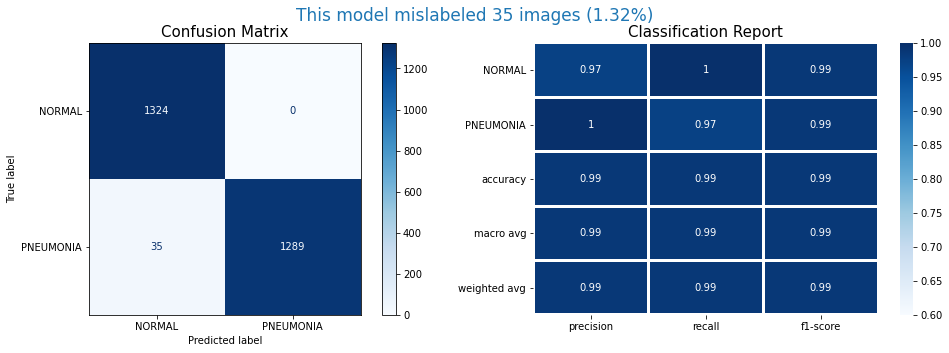

In [68]:
train_preds = final_model.predict(X_train, batch_size=10)
final_train_indices_of_incorrect_predictions = evaluate_model(X_train, y_train, train_preds)

### Test

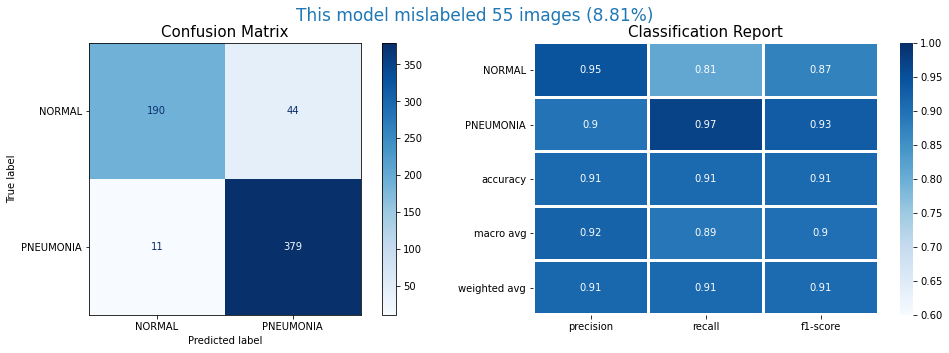

In [69]:
test_preds = final_model.predict(test_images)
final_test_indices_of_incorrect_predictions = evaluate_model(test_images, test_labels, test_preds)

## View misclassified images - TEST data

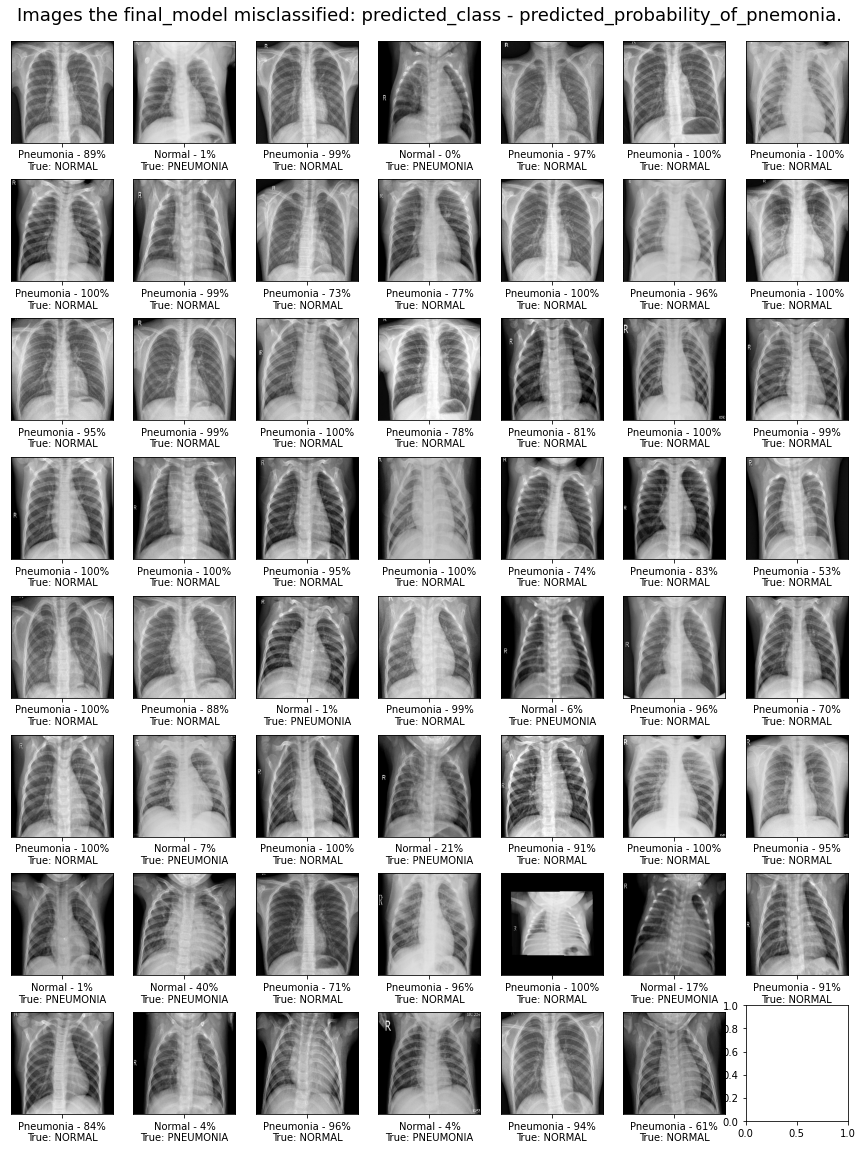

In [70]:
incorrect_images = [test_images[n] for n in final_test_indices_of_incorrect_predictions]
incorrect_true_labels = [test_labels[n] for n in final_test_indices_of_incorrect_predictions]
convert_to_percent = [p*100 for p in test_preds]
predicted_proba = [round(list(convert_to_percent[i])[0]) for i in final_test_indices_of_incorrect_predictions]

fig, axes = plt.subplots(nrows=8, ncols=7, figsize=(15,20))
for n in range(len(incorrect_images)):
    i = n //7
    j = n%7
    ax = axes[i][j]
    ax.imshow(incorrect_images[n].reshape(256, 256), cmap=plt.cm.gray)
    ax.set_xticks([128])
    
    # if the true label is 0 (NORMAL) and model was incorrect then model predicted PNEUMONIA
    if incorrect_true_labels[n] == 0: 
        ax.set_xticklabels([f'Pneumonia - {int(predicted_proba[n])}%\nTrue: NORMAL'])
    # conversely, 
    else:
        ax.set_xticklabels([f'Normal - {int(predicted_proba[n])}%\nTrue: PNEUMONIA'])
    
    ax.set_yticks([])
    # tinker with this, either 2,3,4 to get title centered depending on number of columns
    if n == 3:
        ax.set_title("Images the final_model misclassified: predicted_class - predicted_probability_of_pnemonia.", 
                     fontsize=18, 
                     pad=20);
        
plt.savefig('final_model_misclassified.png')        

## Compare the models

In [71]:
convert_final  = {'final_train': {'pneumonia_recall': .97, 'misclassified': .013, 'accuracy':.99},
                    'final_test': {'pneumonia_recall': .97, 'misclassified': .088, 'accuracy':.91}}

add_this = pd.DataFrame(convert_final).T


compare = pd.concat([compare, add_this])
compare

,pneumonia_recall,misclassified,accuracy
base_train,0.98,0.010,0.99
base_test,0.97,0.150,0.85
cnn_train,1.00,0.000,1.00
cnn_test,0.98,0.131,0.87
reg_train,1.00,0.000,1.00
reg_test,0.99,0.139,0.86
reduced_train,1.00,0.000,1.00
reduced_test,0.98,0.125,0.88
drop_train,1.00,0.002,1.00
drop_test,0.96,0.107,0.89


And a reminder of `metrics_df`

In [72]:
metrics_df

,train_loss,train_acc,test_loss,test_acc,loss_diff,acc_diff
base_model,0.040549,0.988000,0.598990,0.849359,0.558442,0.138641
base_cnn,0.001954,1.000000,0.899908,0.868590,0.897954,0.131410
reg_cnn,1.012247,1.000000,1.839380,0.862179,0.827133,0.137821
reduced_nodes,0.321644,1.000000,1.059986,0.875000,0.738342,0.125000
dropout,0.348353,0.998000,0.967050,0.892628,0.618697,0.105372
final_model,0.113301,0.986782,0.449658,0.911859,0.336356,0.074924


**NOTES:** From the `compare` df you can see the testing-data accuracy-score is highest with this model. You can also see in both training and test data, pneumonia-recall-score is the same. This is important because we want to avoid false negatives slipping by without immediate attention called to them. While it is not the highest of all the models it is important they match because we want a model that is reliably outputing similar results on the unseen data as it did on the training data. As noted above, from the `metrics_df` you can see there is still a very high accuracy-score with both train and test data, ~98.7% and ~91.2% respectively. Additionally, the differences between training and test, loss and accuracy are the lowest in this final model. Remember, this is the `reduce_nodes` model and the only difference is the amount of data that has been used to train the model. This demonstartes the potential for this model to improve with more available data to learn with. 

# Next Steps

While this model has the lowest difference between training and test, loss and accuracy there is still a slight difference. In future iteration, adjusting the lambda coefficient in the l2 regularization may further decrease these differences. Additional methods may also be to reduce the kernel nodes even further, or decrease the dropout p value. 

As we have seen, the more data available to train the model, the better it performs. One option to increase data, while maintaining equal distribution of classes, is instead of down sampling the pneumonia class to match that of the normal class, we can up sample the normal class using data augmentation to match the number of pneumonia cases. This will result in 2534 more "NORMAL" images and increase the total number of training images from 2698 to 7766. 

# Recommendations

My recommendation is that GE Healthcare have built into the CCS machines software the ability to not only flag cases of concern for immediate review, but also have the radiologist either confirm or reject the models predictions. This collaborative approach gives further opportunities for the model to learn and improve performance, and also provides a direct actionable way to improve clinical outcomes and elevate patient experience. This could even potentially mean a CCS machine could learn the proclivities of the particular office or medical practice that it is located in.

An additional recommendation would be to push software updates to existing machines, providing ongoing improvements of predictions. This would be particularly useful for small rural locations who don’t have a high volume of patients. If they can get updates, and improve, due to the images being collected from clinics in more densely populated urban locations then you are giving every doctor’s office around the globe a reason to want this technology for their own practice no matter how big or small they are. 

These recommendations will make these CCS units more marketable to a larger range of businesses. The more CCS machines learning from new cases, the better these AI predictions can get. And the better the predictions, the more justification to bring this technology into every medical practice.

# Thank You

Let's work together, 
- Email: cassigroesbeck@emailplace.com
- GitHub: [@AgathaZareth](https://github.com/AgathaZareth)
- LinkedIn: [Cassarra Groesbeck](https://www.linkedin.com/in/cassarra-groesbeck-a64b75229)

# Visualization for presentation

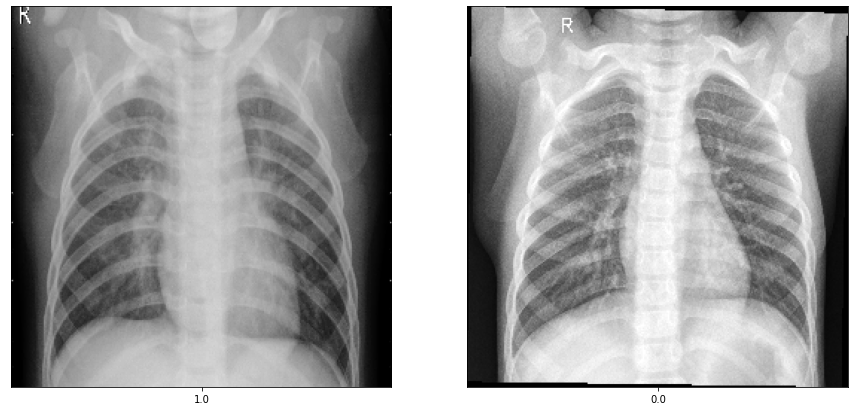

In [140]:
#try_these = random.sample(range(0, len(test_labels)), 2)
if sum([test_labels[n] for n in try_these]) == 1:
    indices_for_presentation = try_these
    images_for_presentation = [test_images[n] for n in indices_for_presentation]
    labels_for_presentation = [test_labels[n] for n in indices_for_presentation]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
    for n in range(len(indices_for_presentation)):
        ax = axes[n] 
        ax.imshow(images_for_presentation[n].reshape(256, 256), cmap=plt.cm.gray)
        ax.set_xticks([128])
        ax.set_xticklabels([labels_for_presentation[n]])
        ax.set_yticks([])
else:
    print('try again')

In [141]:
# get the indices of above images
try_these

[548, 588]

In [142]:
# ensure these are not in list of incorrectly predicted
for n in try_these:
    if n in final_test_indices_of_incorrect_predictions:
        print(n)